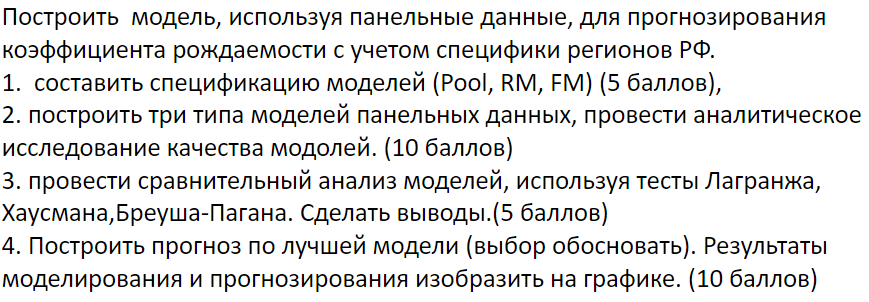

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from linearmodels.datasets import wage_panel
from linearmodels.panel import PooledOLS, PanelOLS, RandomEffects
from linearmodels.panel import compare
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_lm
import statsmodels.stats.api as sms
from linearmodels import IV2SLS
# from linearmodels.iv.results import compare
from statsmodels.compat import lzip
import scipy.stats
import seaborn as sns
import math
import scipy.stats as st
from sklearn.linear_model import LinearRegression as lr
from scipy.stats import f
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

In [ ]:
!pip install linearmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.9/88.9 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 4.2 MB/s eta 0:00:00


#### задание 1

1. Спецификация моделей:
- Модель Pool: y_it = β_0 + β_1x_it + u_it
- Модель RE: y_it = β_0 + β_1x_it + μ_i + ε_it
- Модель FE: y_it = β_1x_it + α_i + ε_it

где y_it - коэффициент рождаемости в регионе i в году t,

x_it - вектор объясняющих переменных,

u_it - случайная ошибка,

μ_i - фиксированный эффект региона,

α_i - фиксированный эффект времени,

ε_it - случайная ошибка.

In [ ]:
df = pd.read_excel(
    'Задача экзамен ПМ20-4.xlsx',
    sheet_name='Вариант4',
    decimal=','
)
#df.drop(columns = [['Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13']], axis = 1, inplace = True)
df = df.iloc[:,:7]
df.head(10)

,Название региона,Год,БЕЗРАБОТИЦА,СООТНОШЕНИЕ Б/Р,ИПЦ НА ЖИЛЬЕ,ИПЦ НА ПРОД ТОВАРЫ,КОЭФ РОЖД НА 1000 ЧЕЛ
0,Республика Дагестан,2017,12.0,292,102.3,98.7,-1.9
1,Республика Дагестан,2018,11.6,304,102.0,102.6,-2.7
2,Республика Дагестан,2019,13.0,332,100.7,103.8,-3.4
3,Республика Ингушетия,2017,26.4,194,97.5,103.9,11.3
4,Республика Ингушетия,2018,26.3,211,98.2,101.1,10.8
5,Республика Ингушетия,2019,26.4,205,99.0,104.2,10.0
6,Кабардино-Балкарская Республика,2017,10.4,510,98.0,101.1,13.1
7,Кабардино-Балкарская Республика,2018,10.4,537,99.2,104.6,13.2
8,Кабардино-Балкарская Республика,2019,10.7,508,95.4,103.3,13.4
9,Карачаево-Черкесская Республика,2017,13.5,576,93.0,101.2,4.3


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Название региона       135 non-null    object 
 1   Год                    135 non-null    int64  
 2   БЕЗРАБОТИЦА            135 non-null    float64
 3   СООТНОШЕНИЕ Б/Р        135 non-null    int64  
 4   ИПЦ НА ЖИЛЬЕ           135 non-null    float64
 5   ИПЦ НА ПРОД ТОВАРЫ     135 non-null    float64
 6   КОЭФ РОЖД НА 1000 ЧЕЛ  135 non-null    float64
dtypes: float64(4), int64(2), object(1)
memory usage: 7.5+ KB


In [ ]:
df.isna().sum()

Название региона         0
Год                      0
БЕЗРАБОТИЦА              0
СООТНОШЕНИЕ Б/Р          0
ИПЦ НА ЖИЛЬЕ             0
ИПЦ НА ПРОД ТОВАРЫ       0
КОЭФ РОЖД НА 1000 ЧЕЛ    0
dtype: int64

In [ ]:
regions = df['Название региона'].unique()

print(regions, "\n\n", f"Всего регионов: {len(regions)}")

['Республика Дагестан' 'Республика Ингушетия'
 'Кабардино-Балкарская Республика' 'Карачаево-Черкесская Республика'
 'Республика Северная Осетия – Алания' 'Чеченская Республика'
 'Ставропольский край' 'Республика Башкортостан' 'Республика Марий Эл'
 'Республика Мордовия' 'Республика Татарстан' 'Удмуртская Республика'
 'Чувашская Республика' 'Пермский край' 'Кировская область'
 'Нижегородская область ' 'Оренбургская область' 'Пензенская область'
 'Самарская область' 'Саратовская область' 'Ульяновская область'
 'Курганская область' 'Свердловская область ' 'Тюменская область'
 'Челябинская область' 'Республика Алтай' 'Республика Тыва'
 'Республика Хакасия' 'Алтайский край' 'Красноярский край'
 'Иркутская область' 'Кемеровская область' 'Новосибирская область '
 'Омская область' 'Томская область' 'Республика Бурятия'
 'Республика Саха (Якутия)' 'Забайкальский край' 'Камчатский край'
 'Приморский край' 'Хабаровский край ' 'Амурская область'
 'Магаданская область' 'Сахалинская область'
 'Еврей

In [ ]:
year = pd.Categorical(df["Год"])
df = df.set_index(["Название региона", "Год"])

df

БЕЗРАБОТИЦА  СООТНОШЕНИЕ Б/Р  ИПЦ НА ЖИЛЬЕ  \
Название региона             Год                                                
Республика Дагестан          2017         12.0              292         102.3   
                             2018         11.6              304         102.0   
                             2019         13.0              332         100.7   
Республика Ингушетия         2017         26.4              194          97.5   
                             2018         26.3              211          98.2   
...                                        ...              ...           ...   
Сахалинская область          2018          5.3              746         121.9   
                             2019          5.2              785         104.6   
Еврейская автономная область 2017          8.3              629          95.3   
                             2018          7.0              800         107.1   
                             2019          6.2              787          98.6   

                                   ИПЦ НА ПРОД ТОВАРЫ  КОЭФ РОЖД НА 1000 ЧЕЛ  
Название региона             Год                                              
Республика Дагестан          2017                98.7                   -1.9  
                             2018               102.6                   -2.7  
                             2019               103.8                   -3.4  
Республика Ингушетия         2017               103.9                   11.3  
                             2018               101.1                   10.8  
...                                               ...                    ...  
Сахалинская область          2018               104.0                   -1.4  
                             2019               104.5                   -2.5  
Еврейская автономная область 2017               100.0                    1.0  
                             2018               105.3                   -0.5  
                             2019               105.1                   -0.6  

[135 rows x 5 columns]

разделить на тестовой 2 и обучающую 7 выборку,
назначить субъекты и годы 2 столбца
все модели только на обучающей выборке
вывести меры качества подгонки r внутригрупп r межгрупп
провести 3 теста сравнить каждый с каждым
получу лучшую модель и на нее делаю прогноз и сделать график

для объед PooledOLS
для фиксированных PanelOLS
для рандомных RandomEffects

при разделении на тест и обуч выборку добавить константу = 1 через метод sm.add_constant, чтобы модель работала. упорядочивает влияние внешних факторов на модель и без нее не будет работать

подготовить аналитическую записку- краткое описание работы

In [ ]:
columns = df.columns.values
print(columns)

['БЕЗРАБОТИЦА' 'СООТНОШЕНИЕ Б/Р' 'ИПЦ НА ЖИЛЬЕ' 'ИПЦ НА ПРОД ТОВАРЫ'
 'КОЭФ РОЖД НА 1000 ЧЕЛ']


1. Спецификация моделей:
- Модель Pool: y_it = β_0 + β_1x_it + u_it
- Модель RE: y_it = β_0 + β_1x_it + μ_i + ε_it
- Модель FE: y_it = β_1x_it + α_i + ε_it


## Задание №2. Модели

**Построить три типа моделей панельных данных, провести аналитическое исследование качества модолей. (10 баллов)**

In [ ]:
df.corr()

,БЕЗРАБОТИЦА,СООТНОШЕНИЕ Б/Р,ИПЦ НА ЖИЛЬЕ,ИПЦ НА ПРОД ТОВАРЫ,КОЭФ РОЖД НА 1000 ЧЕЛ
БЕЗРАБОТИЦА,1.000000,-0.727914,-0.206837,-0.011957,0.462238
СООТНОШЕНИЕ Б/Р,-0.727914,1.000000,0.254727,0.222812,-0.329663
ИПЦ НА ЖИЛЬЕ,-0.206837,0.254727,1.000000,0.166564,-0.125910
ИПЦ НА ПРОД ТОВАРЫ,-0.011957,0.222812,0.166564,1.000000,0.011261
КОЭФ РОЖД НА 1000 ЧЕЛ,0.462238,-0.329663,-0.125910,0.011261,1.000000


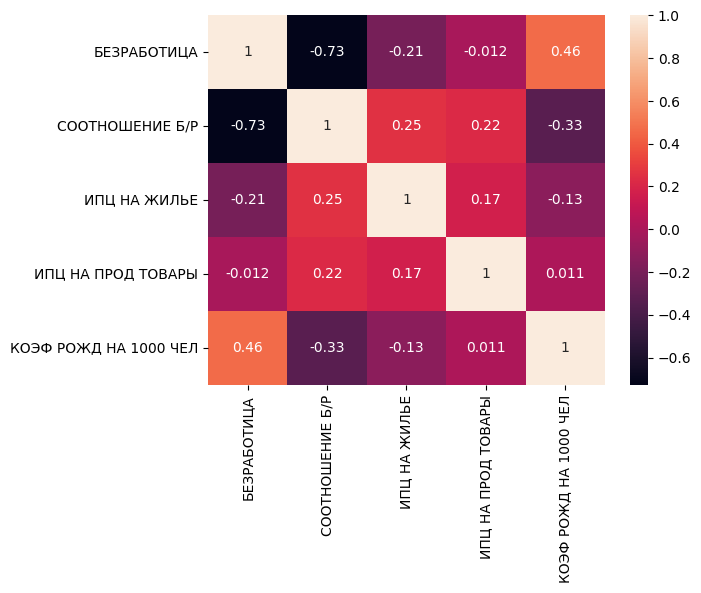

In [ ]:
sns.heatmap(df.corr(), annot=True)
plt.show()

In [ ]:
print(df.columns.values)

['БЕЗРАБОТИЦА' 'СООТНОШЕНИЕ Б/Р' 'ИПЦ НА ЖИЛЬЕ' 'ИПЦ НА ПРОД ТОВАРЫ'
 'КОЭФ РОЖД НА 1000 ЧЕЛ']


In [ ]:
# Определение объясняющих переменных

X = df[['БЕЗРАБОТИЦА', 'СООТНОШЕНИЕ Б/Р', 'ИПЦ НА ЖИЛЬЕ','ИПЦ НА ПРОД ТОВАРЫ']]
X = sm.add_constant(X)

# Определение зависимой переменной
y = df['КОЭФ РОЖД НА 1000 ЧЕЛ']

In [ ]:
# Строим объединенную модель панельных данных
pool_model = PooledOLS(y, X)
results = pool_model.fit()

# Выводим результаты
print(results)

                            PooledOLS Estimation Summary                           
Dep. Variable:     КОЭФ РОЖД НА 1000 ЧЕЛ   R-squared:                        0.2152
Estimator:                     PooledOLS   R-squared (Between):              0.2139
No. Observations:                    135   R-squared (Within):               0.2831
Date:                   Thu, Sep 14 2023   R-squared (Overall):              0.2152
Time:                           03:31:48   Log-likelihood                   -392.94
Cov. Estimator:               Unadjusted                                           
                                           F-statistic:                      8.9117
Entities:                             45   P-value                           0.0000
Avg Obs:                          3.0000   Distribution:                   F(4,130)
Min Obs:                          3.0000                                           
Max Obs:                          3.0000   F-statistic (robust):            

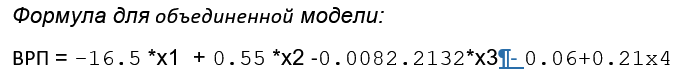

In [ ]:
# модель с фиксированными эффектами

fe_model = PanelOLS(y, X, entity_effects=True)
fixed_results = fe_model.fit()

print(fixed_results.summary)

                            PanelOLS Estimation Summary                            
Dep. Variable:     КОЭФ РОЖД НА 1000 ЧЕЛ   R-squared:                        0.6039
Estimator:                      PanelOLS   R-squared (Between):              0.1703
No. Observations:                    135   R-squared (Within):               0.6039
Date:                   Thu, Sep 14 2023   R-squared (Overall):              0.1781
Time:                           03:31:48   Log-likelihood                   -76.266
Cov. Estimator:               Unadjusted                                           
                                           F-statistic:                      32.780
Entities:                             45   P-value                           0.0000
Avg Obs:                          3.0000   Distribution:                    F(4,86)
Min Obs:                          3.0000                                           
Max Obs:                          3.0000   F-statistic (robust):            

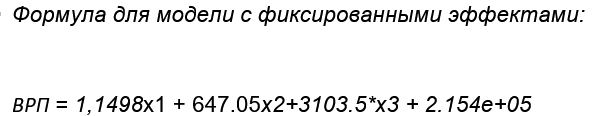

In [ ]:
# модель с рандомными эффектами
re_model = RandomEffects(y, X)

random_results = re_model.fit()

print(random_results.summary)


                          RandomEffects Estimation Summary                         
Dep. Variable:     КОЭФ РОЖД НА 1000 ЧЕЛ   R-squared:                        0.5190
Estimator:                 RandomEffects   R-squared (Between):              0.1752
No. Observations:                    135   R-squared (Within):               0.6033
Date:                   Thu, Sep 14 2023   R-squared (Overall):              0.1830
Time:                           03:31:49   Log-likelihood                   -104.17
Cov. Estimator:               Unadjusted                                           
                                           F-statistic:                      35.073
Entities:                             45   P-value                           0.0000
Avg Obs:                          3.0000   Distribution:                   F(4,130)
Min Obs:                          3.0000                                           
Max Obs:                          3.0000   F-statistic (robust):            

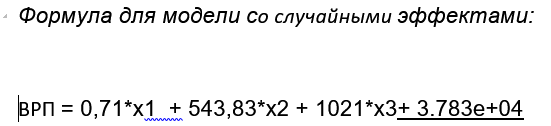

In [ ]:
df["pool"] = pooled_res.fitted_values
df["fe"] = fe_res.fitted_values
df["re"] = re_res.fitted_values

df

БЕЗРАБОТИЦА  СООТНОШЕНИЕ Б/Р  ИПЦ НА ЖИЛЬЕ  \
Название региона             Год                                                
Республика Дагестан          2017         12.0              292         102.3   
                             2018         11.6              304         102.0   
                             2019         13.0              332         100.7   
Республика Ингушетия         2017         26.4              194          97.5   
                             2018         26.3              211          98.2   
...                                        ...              ...           ...   
Сахалинская область          2018          5.3              746         121.9   
                             2019          5.2              785         104.6   
Еврейская автономная область 2017          8.3              629          95.3   
                             2018          7.0              800         107.1   
                             2019          6.2              787          98.6   

                                   ИПЦ НА ПРОД ТОВАРЫ  КОЭФ РОЖД НА 1000 ЧЕЛ  \
Название региона             Год                                               
Республика Дагестан          2017                98.7                   -1.9   
                             2018               102.6                   -2.7   
                             2019               103.8                   -3.4   
Республика Ингушетия         2017               103.9                   11.3   
                             2018               101.1                   10.8   
...                                               ...                    ...   
Сахалинская область          2018               104.0                   -1.4   
                             2019               104.5                   -2.5   
Еврейская автономная область 2017               100.0                    1.0   
                             2018               105.3                   -0.5   
                             2019               105.1                   -0.6   

                                        pool        fe        re  
Название региона             Год                                  
Республика Дагестан          2017   2.489930  1.367285  4.310568  
                             2018   2.481134  1.177401  4.026070  
                             2019   3.369967  1.195812  4.216801  
Республика Ингушетия         2017  10.904084  2.641969  9.405978  
                             2018  10.696051  2.681187  9.275102  
...                                      ...       ...       ...  
Сахалинская область          2018  -1.149638 -0.618807 -1.894114  
                             2019  -0.830909 -0.580407 -1.916006  
Еврейская автономная область 2017   0.776734  0.280431  0.553783  
                             2018   0.183112 -0.519290 -1.565945  
                             2019  -0.121788 -0.469690 -1.528386  

[135 rows x 8 columns]

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=np.arange(1, len(df)+1), y=df['КОЭФ РОЖД НА 1000 ЧЕЛ'],
                    mode='lines+markers',
                    name='Исходный ряд')
)

fig.add_trace(go.Scatter(x=np.arange(1, len(df)+1), y=df['pool'],
                    mode='lines+markers',
                    name='pool')
)

fig.add_trace(go.Scatter(x=np.arange(1, len(df)+1), y=df['fe'],
                    mode='lines+markers',
                    name='fe')
)

fig.add_trace(go.Scatter(x=np.arange(1, len(df)+1), y=df['re'],
                    mode='lines+markers',
                    name='re')
)

fig.update_layout(title='Сравнение исходного ряда и модели', width=1000, height=650)

fig.show()

In [ ]:
print(compare({"FE": fe_res, "RE": re_res, "Pooled": pooled_res}))

                                           Model Comparison                                          
                                               FE                        RE                    Pooled
-----------------------------------------------------------------------------------------------------
Dep. Variable               КОЭФ РОЖД НА 1000 ЧЕЛ     КОЭФ РОЖД НА 1000 ЧЕЛ     КОЭФ РОЖД НА 1000 ЧЕЛ
Estimator                                PanelOLS             RandomEffects                 PooledOLS
No. Observations                              135                       135                       135
Cov. Est.                              Unadjusted                Unadjusted                Unadjusted
R-squared                                  0.1529                    0.5190                    0.2152
R-Squared (Within)                         0.3709                    0.6033                    0.2831
R-Squared (Between)                        0.0871                    0.1752       

## Задание №3. Тесты

**Провести сравнительный анализ моделей, используя:**
- **тест Лагранжа**
- **тест Хаусмана**
- **тест Бреуша-Пагана**

**Сделать выводы. (5 баллов)**

In [ ]:
# тест Хаусмана Fixed vs Random
print(compare({'Fixed': fixed_results , 'Random': random_results}))

                              Model Comparison                             
                                            Fixed                    Random
---------------------------------------------------------------------------
Dep. Variable               КОЭФ РОЖД НА 1000 ЧЕЛ     КОЭФ РОЖД НА 1000 ЧЕЛ
Estimator                                PanelOLS             RandomEffects
No. Observations                              135                       135
Cov. Est.                              Unadjusted                Unadjusted
R-squared                                  0.6039                    0.5190
R-Squared (Within)                         0.6039                    0.6033
R-Squared (Between)                        0.1703                    0.1752
R-Squared (Overall)                        0.1781                    0.1830
F-statistic                                32.780                    35.073
P-value (F-stat)                           0.0000                    0.0000
============

In [ ]:
# random vs pooled
pooled_olsr_model = sm.OLS(endog=y, exog=X)
pooled_olsr_model_results = pooled_olsr_model.fit()
print('=============== Pooled OLSR Model ===============')
print(pooled_olsr_model_results.summary())

=============== Pooled OLSR Model ===============
                              OLS Regression Results                             
Dep. Variable:     КОЭФ РОЖД НА 1000 ЧЕЛ   R-squared:                       0.215
Model:                               OLS   Adj. R-squared:                  0.191
Method:                    Least Squares   F-statistic:                     8.912
Date:                   Thu, 14 Sep 2023   Prob (F-statistic):           2.16e-06
Time:                           03:33:27   Log-Likelihood:                -392.94
No. Observations:                    135   AIC:                             795.9
Df Residuals:                        130   BIC:                             810.4
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

In [ ]:
unit_names = list(set(names))
n = len(unit_names)

#T=number of time periods per unit
T = df.shape[0] / n

#N=total number of rows in the panel data set
N = n*T

#k=number of regression variables of the Pooled OLS model
k = len(X)+1

n, T, N, k

(4, 33.75, 135.0, 136)

In [ ]:
y_var_name = y
X_var_names = X

In [ ]:
X_var_names

const  БЕЗРАБОТИЦА  СООТНОШЕНИЕ Б/Р  \
Название региона             Год                                         
Республика Дагестан          2017    1.0         12.0              292   
                             2018    1.0         11.6              304   
                             2019    1.0         13.0              332   
Республика Ингушетия         2017    1.0         26.4              194   
                             2018    1.0         26.3              211   
...                                  ...          ...              ...   
Сахалинская область          2018    1.0          5.3              746   
                             2019    1.0          5.2              785   
Еврейская автономная область 2017    1.0          8.3              629   
                             2018    1.0          7.0              800   
                             2019    1.0          6.2              787   

                                   ИПЦ НА ЖИЛЬЕ  ИПЦ НА ПРОД ТОВАРЫ  
Название региона             Год                                     
Республика Дагестан          2017         102.3                98.7  
                             2018         102.0               102.6  
                             2019         100.7               103.8  
Республика Ингушетия         2017          97.5               103.9  
                             2018          98.2               101.1  
...                                         ...                 ...  
Сахалинская область          2018         121.9               104.0  
                             2019         104.6               104.5  
Еврейская автономная область 2017          95.3               100.0  
                             2018         107.1               105.3  
                             2019          98.6               105.1  

[135 rows x 5 columns]

In [ ]:
y_var_name

Название региона              Год 
Республика Дагестан           2017    -1.9
                              2018    -2.7
                              2019    -3.4
Республика Ингушетия          2017    11.3
                              2018    10.8
                                      ... 
Сахалинская область           2018    -1.4
                              2019    -2.5
Еврейская автономная область  2017     1.0
                              2018    -0.5
                              2019    -0.6
Name: КОЭФ РОЖД НА 1000 ЧЕЛ, Length: 135, dtype: float64

## Тест Бреуша-Пагана (множителей Лагранжа)

In [ ]:
default_df = pd.read_excel(
    'Задача экзамен ПМ20-4.xlsx',
    sheet_name='Вариант4',
    decimal=','
)
#df.drop(columns = [['Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13']], axis = 1, inplace = True)
default_df = default_df.iloc[:,:7]
default_df.head(10)

,Название региона,Год,БЕЗРАБОТИЦА,СООТНОШЕНИЕ Б/Р,ИПЦ НА ЖИЛЬЕ,ИПЦ НА ПРОД ТОВАРЫ,КОЭФ РОЖД НА 1000 ЧЕЛ
0,Республика Дагестан,2017,12.0,292,102.3,98.7,-1.9
1,Республика Дагестан,2018,11.6,304,102.0,102.6,-2.7
2,Республика Дагестан,2019,13.0,332,100.7,103.8,-3.4
3,Республика Ингушетия,2017,26.4,194,97.5,103.9,11.3
4,Республика Ингушетия,2018,26.3,211,98.2,101.1,10.8
5,Республика Ингушетия,2019,26.4,205,99.0,104.2,10.0
6,Кабардино-Балкарская Республика,2017,10.4,510,98.0,101.1,13.1
7,Кабардино-Балкарская Республика,2018,10.4,537,99.2,104.6,13.2
8,Кабардино-Балкарская Республика,2019,10.7,508,95.4,103.3,13.4
9,Карачаево-Черкесская Республика,2017,13.5,576,93.0,101.2,4.3


In [ ]:
pooled_olsr_model = sm.OLS(endog=y, exog=X)
pooled_olsr_model_results = pooled_olsr_model.fit()
print('=============== Pooled OLSR Model ===============')
print(pooled_olsr_model_results.summary())

=============== Pooled OLSR Model ===============
                              OLS Regression Results                             
Dep. Variable:     КОЭФ РОЖД НА 1000 ЧЕЛ   R-squared:                       0.215
Model:                               OLS   Adj. R-squared:                  0.191
Method:                    Least Squares   F-statistic:                     8.912
Date:                   Thu, 14 Sep 2023   Prob (F-statistic):           2.16e-06
Time:                           03:36:30   Log-Likelihood:                -392.94
No. Observations:                    135   AIC:                             795.9
Df Residuals:                        130   BIC:                             810.4
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

In [ ]:
# df_pooled = pd.concat([default_df['Название региона'], pooled_olsr_model_results.resid], axis=1)

df_pooled_olsr_resid_with_unitnames = pd.concat([default_df['Название региона'], pooled_olsr_model_results.resid], axis=1)

df_pooled_olsr_resid_group_means = df_pooled_olsr_resid_with_unitnames.groupby('Название региона').mean()
ssr_grouped_means=(df_pooled_olsr_resid_group_means[0]**2).sum()
ssr_pooled_olsr=pooled_olsr_model_results.ssr
LM_statistic = (n*T)/(2*(T-1)) * math.pow(((T*T*ssr_grouped_means)/ssr_pooled_olsr - 1), 2)

print('BP LM Statistic=' + str(LM_statistic))

BP LM Statistic=2.0610687022900764


## Хи-квадрат

In [ ]:
alpha = 0.05
chi2_critical_value = st.chi2.ppf((1.0-alpha), 1)
print('chi2_critical_value='+str(chi2_critical_value))

reg= sm.OLS(y, X).fit(cov_type="HC3")

names = ['p-value']
test_result = sms.het_breuschpagan(reg.resid, reg.model.exog)
print('p-value теста Бреуша-Пагана: ' + str(test_result[1]))

chi2_critical_value=3.841458820694124
p-value теста Бреуша-Пагана: 0.9755016719870659


## Вывод

Хи-квадрат = 3.84

Тест Бреуша-Пагана (множителей Лагранжа) = 0.9755

Тест Бреуша-Пагана < критич. значения Хи-квадрат при α=0.05, значит, модель со случайными эффектами незначима при alpha = 0.05.

## Pooled VS Fixed

In [ ]:
# Определение объясняющих переменных
X = default_df[['БЕЗРАБОТИЦА', 'СООТНОШЕНИЕ Б/Р', 'ИПЦ НА ЖИЛЬЕ','ИПЦ НА ПРОД ТОВАРЫ']]

# Определение зависимой переменной
y = default_df['КОЭФ РОЖД НА 1000 ЧЕЛ']

In [ ]:
df_for_chow = default_df
#df_for_chow=df_for_chow.sort_values(by='treat', ascending=True).reset_index().drop(columns=['index'])

for i in range(0, len(df_for_chow)):
    if df_for_chow['ИПЦ НА ПРОД ТОВАРЫ'][i] == 103:
        break_point = i
        break


def linear_residuals(X, y):
    #строим линейную модель
    model = lr().fit(X, y)

    # строим датафрейм с предсказанными значениями целевой метрики
    summary_result = pd.DataFrame(columns = ['y_hat'])
    yhat_list = [float(i) for i in np.ndarray.tolist(model.predict(X))]
    summary_result['y_hat'] = yhat_list

    # добавляем к датафрейму реальные значения целевой метрики
    summary_result['y_actual'] = y.values

    # вычисляем остатки
    summary_result['residuals'] = summary_result.y_actual - summary_result.y_hat

    # возводим остатки в квадрат
    summary_result['residuals_sq'] = summary_result.residuals ** 2

    return summary_result


# пишем функцию, которая считает сумму квадратов остатков
def calculate_RSS(X, y):
    resid_data = linear_residuals(X, y)
    rss = resid_data.residuals_sq.sum()
    return rss


def ChowTest(X, y, last_index_in_model_1, first_index_in_model_2):
    rss_pooled = calculate_RSS(X, y)
    # делим выборку на две подвыборке, в которой есть “слом”, наличие которого мы хотим проверить, и в котором слома нет

    X1 = X.loc[:last_index_in_model_1]
    y1 = y.loc[:last_index_in_model_1]
    rss1 = calculate_RSS(X1, y1)

    X2 = X.loc[first_index_in_model_2:]
    y2 = y.loc[first_index_in_model_2:]
    rss2 = calculate_RSS(X2, y2)

    # находим кол-во регрессоров + 1 для константы
    k = X.shape[1] + 1

    # находим кол-во наблюдений до слома
    N1 = X1.shape[0]

    # находим кол-во наблюдений после слома
    N2 = X2.shape[0]

    # вычисляем числитель для статистики Чоу
    numerator = (rss_pooled - (rss1 + rss2)) / k

    # вычисляем знаменатель для статистики Чоу
    denominator = (rss1 + rss2) / (N1 + N2 - 2 * k)

    # вычисляем статистику Чоу
    Chow_Stat = numerator / denominator

    # статистика Чоу имеет распределение Фишера с k и N1 + N2 - 2k степенями свободы
    # считаю p-value
    p_value = 1 - f.cdf(Chow_Stat, dfn = 5, dfd = (N1 + N2 - 2 * k))
    result = (Chow_Stat, p_value)

    return result


ChowTest(y=y, X=X,
        last_index_in_model_1=break_point-1,
        first_index_in_model_2=break_point)[1]

0.3660271615629679

## Вывод

P-value теста Чоу равно 0.36 <0.05. Между pooled OLS и FE выбираем модель с фиксированными эффектами.

## Предпочтительная модель - с фиксированными эффектами

H0 гипотеза:

    preferred_model = 'с фиксированными эффектами', так как p-value = 0.01  < 0.05 иначе 'со случайными эффектами'  или 'объединенная модель'
    
была принята

    Построили
    1. Объединенную модель
    2. Модель с фиксированными эффектами
    3. Модель со случайными эффектами
    
    сделали выбор в пользу модели с фиксированными переменными
    По 3-м моделям панельных данных рассчитаны прогнозные значения ВРП каждого региона на 2022 год
    
    Построенные модели панельных данных позволили рассчитать прогнозные значения ВРП каждого федерального округа

In [ ]:
names = ['Lagrange multiplier statistic', 'p-value',
         'f-value', 'f p-value']

pool_test_result = sms.het_breuschpagan(pooled_res.resids, pooled_res.model.exog.dataframe)
fe_test_result = sms.het_breuschpagan(fe_res.resids, fe_res.model.exog.dataframe)
re_test_result = sms.het_breuschpagan(re_res.resids, re_res.model.exog.dataframe)

stats_df = pd.DataFrame(data={
    "pool": pool_test_result,
    "fe": fe_test_result,
    "re": re_test_result
}, index=names)

stats_df

,pool,fe,re
Lagrange multiplier statistic,0.479119,3.714534,0.090799
p-value,0.975502,0.446016,0.999000
f-value,0.115754,0.919541,0.021874
f p-value,0.976750,0.454731,0.999057


In [ ]:
rsquared_df = pd.DataFrame(
    data={
        'pool': [pooled_res.rsquared, pooled_res.rsquared_between, pooled_res.rsquared_overall, pooled_res.rsquared_within],
        're': [re_res.rsquared, re_res.rsquared_between, re_res.rsquared_overall, re_res.rsquared_within],
        'fe': [fe_res.rsquared, fe_res.rsquared_between, fe_res.rsquared_overall, fe_res.rsquared_within],
    },
    index=['rsquared', 'rsquared_between', 'rsquared_overall', 'rsquared_within',]
)

rsquared_df

,pool,re,fe
rsquared,0.215197,0.519039,0.152899
rsquared_between,0.213940,0.175187,0.087083
rsquared_overall,0.215197,0.182969,0.092241
rsquared_within,0.283087,0.603332,0.370876


In [ ]:
lm_pool_results = linear_lm(pooled_res.resids, pooled_res.model.exog.values2d)
lm_fe_results = linear_lm(fe_res.resids, fe_res.model.exog.values2d)
lm_re_results = linear_lm(re_res.resids, re_res.model.exog.values2d)

In [ ]:
stats_df = pd.DataFrame(
    data={
        "pool": [pool_test_result[0], lm_pool_results[0]],
        "fe": [fe_test_result[0], lm_fe_results[0]],
        "re": [re_test_result[0], lm_re_results[0]]
    },
    index=["breush_pagan", "lagrange"]
)

stats_df

,pool,fe,re
breush_pagan,0.479119,3.714534,0.090799
lagrange,4.448446,0.599895,9.606016


In [ ]:
def breusch_pagan_test(pooled_res, re_res, years, n):
    x = np.column_stack([np.ones(2*n), np.arange(2*n) % years])
    y = np.concatenate((pooled_res.resids, re_res.resids))
    _, p_value, _, _ = sms.het_breuschpagan(y, x)
    return p_value

p_value = breusch_pagan_test(pooled_res, re_res, 3, pooled_res.nobs)
print(f"P-value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("Модель со случ. эффектами является предпочтительной.")
else:
    print("Модель пула является предпочтительной.")

P-value: 0.9442970374165787
Модель пула является предпочтительной.


In [ ]:
lm_comp = compare({"Pooled": pooled_res, "Fixed Effects": fe_res, "Random Effects": re_res})
lagrange_statistic = lm_comp.f_statistic

print("Статистика теста Лагранжа:\n", lagrange_statistic, end='\n\n')

alpha = 0.05
test_statistic = lagrange_statistic['F stat']
p_value = lagrange_statistic['P-value']
if float(p_value[0]) < alpha:
    print("Модель с случ эффектами предпочтительна")
else:
    print("Модель пула предпочтительна")

Статистика теста Лагранжа:
                    F stat       P-value
Pooled           8.911674  2.163595e-06
Fixed Effects    3.790447  6.978717e-03
Random Effects  35.073012  1.110223e-16

Модель с случ эффектами предпочтительна


In [ ]:
def hausman(fe, re):
    b = fe.params
    B = re.params
    v_b = fe.cov
    v_B = re.cov
    df = b[np.abs(b) < 1e8].size
    chi2 = np.dot((b - B).T, np.linalg.inv(v_b - v_B).dot(b - B))
    pval = scipy.stats.chi2.sf(chi2, df)
    return chi2, df, pval


hausman_results = hausman(fe_res, re_res)
print(f'chi-Squared: {str(hausman_results[0])}')
print(f'p-Value: {str(hausman_results[2])}')

if hausman_results[0] < hausman_results[2]:
  print('Модель с фикс эффектами предпочтительнее.')
else:
  print('Модель пула предпочтительнее.')

chi-Squared: 9.977368812479183
p-Value: 0.07587903629587979
Модель пула предпочтительнее.


## Задание №4. Прогноз

**Построить прогноз по лучшей модели (выбор обосновать). Результаты моделирования и прогнозирования изобразить на графике. (10 баллов)**

In [ ]:
default_df.head(3)

,Название региона,Год,БЕЗРАБОТИЦА,СООТНОШЕНИЕ Б/Р,ИПЦ НА ЖИЛЬЕ,ИПЦ НА ПРОД ТОВАРЫ,КОЭФ РОЖД НА 1000 ЧЕЛ
0,Республика Дагестан,2017,12.0,292,102.3,98.7,-1.9
1,Республика Дагестан,2018,11.6,304,102.0,102.6,-2.7
2,Республика Дагестан,2019,13.0,332,100.7,103.8,-3.4


In [ ]:
# Определение объясняющих переменных
exog_vars = ['БЕЗРАБОТИЦА', 'СООТНОШЕНИЕ Б/Р', 'ИПЦ НА ЖИЛЬЕ','ИПЦ НА ПРОД ТОВАРЫ']
X = default_df[exog_vars]
X = sm.add_constant(X)

# Определение зависимой переменной
y = default_df['КОЭФ РОЖД НА 1000 ЧЕЛ']

In [ ]:
labelencoder = LabelEncoder()
for ax in X:
    if X[ax].dtypes == 'object':
        print(ax)
        X[ax] = labelencoder.fit_transform(X[ax].values)

X.head(10)

,const,БЕЗРАБОТИЦА,СООТНОШЕНИЕ Б/Р,ИПЦ НА ЖИЛЬЕ,ИПЦ НА ПРОД ТОВАРЫ
0,1.0,12.0,292,102.3,98.7
1,1.0,11.6,304,102.0,102.6
2,1.0,13.0,332,100.7,103.8
3,1.0,26.4,194,97.5,103.9
4,1.0,26.3,211,98.2,101.1
5,1.0,26.4,205,99.0,104.2
6,1.0,10.4,510,98.0,101.1
7,1.0,10.4,537,99.2,104.6
8,1.0,10.7,508,95.4,103.3
9,1.0,13.5,576,93.0,101.2


In [ ]:
X = default_df[['БЕЗРАБОТИЦА', 'СООТНОШЕНИЕ Б/Р', 'ИПЦ НА ЖИЛЬЕ','ИПЦ НА ПРОД ТОВАРЫ']]
X = sm.add_constant(X)

# Определение зависимой переменной
y = default_df['КОЭФ РОЖД НА 1000 ЧЕЛ']

In [ ]:
fe_model = PanelOLS(y, X, entity_effects=True)
fixed_results = fe_model.fit()

print(fixed_results.summary)

ValueError: ignored

In [ ]:
# предсказание
y_pred = fixed_results.predict(X)
y_pred

ValueError: ignored

In [ ]:
fig, ax = plt.subplots(figsize=(25, 10))
ax.plot(y.values.reshape(1,-1)[0].tolist(), label='Исходный ряд')
ax.plot(y_pred.values.reshape(1,-1)[0].tolist(), label='Предсказанный ряд')
ax.legend()
ax.set_xlabel('Index')
ax.set_ylabel('Coefficient')
plt.show()

In [ ]:
MSE = ((y.values.reshape(1,-1)[0]-y_pred.values.reshape(1,-1)[0])**2).sum()
MSE

# Вывод
Наиболее предпочтительной оказалась модель с фиксированными эффектами, мы построили предсказание с ошибкой  = 1430.643

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=np.arange(1, len(df)+1), y=df['КОЭФ РОЖД НА 1000 ЧЕЛ'],
                    mode='lines+markers',
                    name='Исходный ряд')
)

fig.add_trace(go.Scatter(x=np.arange(1, len(df)+1), y=re_res.fitted_values['fitted_values'],
                    mode='lines+markers',
                    name='pool')
)


fig.update_layout(title='Сравнение исходного ряда и модели', width=1000, height=650)

fig.show()